In [41]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [42]:
import numpy as np
import pandas as pd

In [43]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [44]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [45]:
#engine = create_engine("sqlite:///Resources/hawaii.sqlite")
engine = create_engine("sqlite:///hawaii.sqlite")

In [46]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [47]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [48]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [49]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [50]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_data_point = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
#last_data_point 
#2017-08-23

last_data_point = last_data_point[0]

# Calculate the date 1 year ago from the last data point in the database

prev_year = dt.datetime.strptime(last_data_point,"%Y-%m-%d") - dt.timedelta(days=366)
prev_year




datetime.datetime(2016, 8, 22, 0, 0)

In [51]:

# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column

result = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= prev_year).all()
#result

In [52]:
# Sort the dataframe by date
df = pd.DataFrame(result, columns=['date', 'precipitation'])
df.set_index(df['date'], inplace=True)
#df

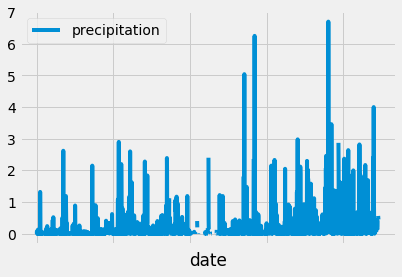

In [53]:
# Use Pandas Plotting with Matplotlib to plot the data
df.plot(x_compat=True)

plt.show()


In [54]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [55]:
# Design a query to show how many stations are available in this dataset?
avail_station=session.query(func.count(Station.station)).all()
avail_station

[(9)]

In [56]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [57]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').all()



[(54.0, 85.0, 71.66378066378067)]

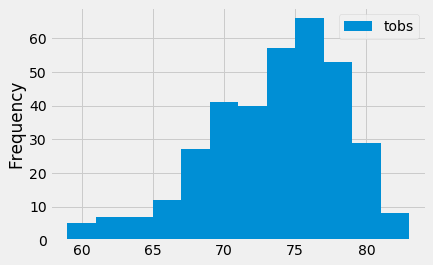

In [58]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

result1 = session.query(Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date >= prev_year).all()
df = pd.DataFrame(result1, columns=['tobs'])
df.plot.hist(bins=12)
plt.show()

In [59]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [60]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

prev_year_start = dt.date(2018, 8, 16) - dt.timedelta(days=366)
prev_year_end = dt.date(2018, 8, 23) - dt.timedelta(days=366)

tmin, tavg, tmax = calc_temps(prev_year_start.strftime("%Y-%m-%d"), prev_year_end.strftime("%Y-%m-%d"))[0]
print(tmin, tavg, tmax)

70.0 78.29032258064517 85.0


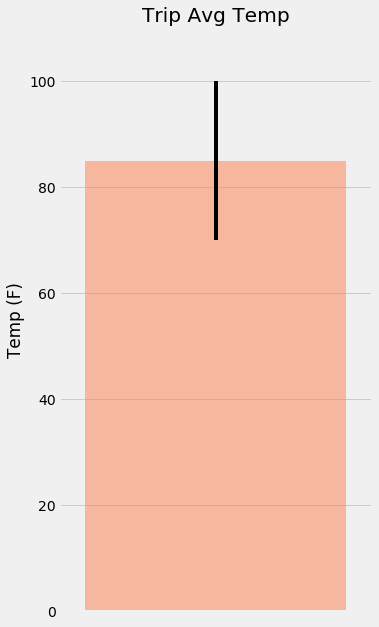

In [62]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

fig, ax = plt.subplots(figsize=(5,10))
xpos = 1
yerr = tmax-tmin

bar = ax.bar(xpos, tmax, yerr=yerr, alpha=0.5, color='coral', align="center")
ax.set(xticks=range(xpos), title="Trip Avg Temp", ylabel="Temp (F)")
ax.margins(.1, .1)

fig.show()

In [63]:
start_date = '2012-02-28'
end_date = '2012-03-05'

#start_date = '2018-08-16'
#end_date = '2018-08-23'

rainfall = [Station.station, Station.name, Station.latitude, 
       Station.longitude, Station.elevation, func.sum(Measurement.prcp)]
#rainfall

In [64]:
results = session.query(*rainfall).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= start_date).\
    filter(Measurement.date <= end_date).\
    group_by(Station.name).order_by(func.sum(Measurement.prcp).desc()).all()
print(results)

[('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 11.08), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 10.32), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 5.79), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 3.8400000000000003), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 2.92), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 1.1800000000000002), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.76), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.03), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0)]


## Optional Challenge Assignment

In [65]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [66]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [67]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

t_start = '2017-01-01'
t_end = '2017-01-15'

# Use the start and end date to create a range of dates


# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date

tday_df = pd.date_range(t_start, t_end, freq='D')
mo_day = tday_df.strftime('%m-%d')

normals = []
for date in mo_day:
    normals.append(*daily_normals(date))
    
normals

[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0),
 (57.0, 67.16071428571429, 75.0),
 (58.0, 67.9298245614035, 78.0),
 (62.0, 69.74137931034483, 77.0),
 (57.0, 67.3103448275862, 78.0),
 (57.0, 67.4074074074074, 81.0),
 (57.0, 67.25454545454545, 77.0),
 (58.0, 69.52631578947368, 77.0),
 (56.0, 69.31372549019608, 78.0)]

In [68]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df = pd.DataFrame(normals, columns=['tmin', 'tavg', 'tmax'])
#df
df['date'] = tday_df
df.set_index(['date'],inplace=True)
df.head()

,tmin,tavg,tmax
date,,,
2017-01-01,62.0,69.153846,77.0
2017-01-02,60.0,69.396226,77.0
2017-01-03,62.0,68.909091,77.0
2017-01-04,58.0,70.000000,76.0
2017-01-05,56.0,67.964286,76.0


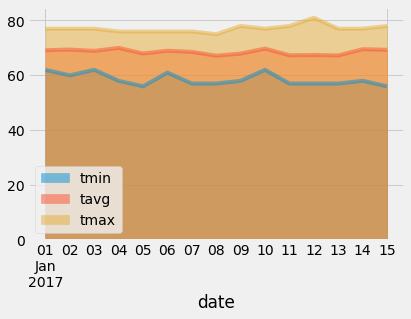

In [69]:
# Plot the daily normals as an area plot with `stacked=False`
df.plot.area(stacked=False)

plt.show()
